<a href="https://colab.research.google.com/github/cawcawlabs/ouster_lidar_appnotes/blob/cawcawlabs-readme_update/Ouster_SDK_%2B_IMU_%3D_AHRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ouster SDK + internal 6-axis IMU


# Setup

Download sample lidar pcap recording, install ouster-sdk

In [ ]:
%cd /content/

!wget https://data.ouster.io/sdk-samples/Rev-05/OS1-128_Rev-05_Urban-Drive/OS1-128_Rev-05_Urban-Drive.zip

!unzip /content/OS1-128_Rev-05_Urban-Drive.zip

!pip install 'ouster-sdk'

!pip install ahrs

##EXTRACTING LIDAR DATA FROM PCAP/JSON

In [ ]:
pcap_path = '/content/OS1-128_Rev-05_Urban-Drive.pcap'
metadata_path = '/content/OS1-128_Rev-05_Urban-Drive.json'

from ouster import client
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

#Process metadata from 
with open(metadata_path, 'r') as f:
    info = client.SensorInfo(f.read())

from ouster import pcap
source = pcap.Pcap(pcap_path, info)

from contextlib import closing
from more_itertools import nth
with closing(client.Scans(source)) as scans:
    scan = nth(scans, 100)

#range
range_field = scan.field(client.ChanField.RANGE)
range_img = client.destagger(info, range_field)

#reflectivity
ref_field = scan.field(client.ChanField.REFLECTIVITY)
ref_val = client.destagger(info, ref_field)
#ref_img = (ref_val / np.max(ref_val) * 255).astype(np.uint8)
ref_img = ref_val.astype(np.uint8)

combined_img = np.dstack((ref_img, ref_img, ref_img))

##LET'S INSPECT THE SCAN IMAGE

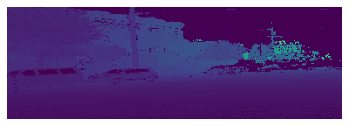

In [ ]:

import matplotlib.pyplot as plt
plt.imshow(range_img[:, 640:1024], resample=False)
plt.axis('off')
plt.show()

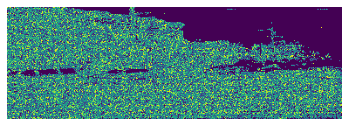

In [ ]:
plt.imshow(ref_img[:, 640:1024], resample=False)
plt.axis('off')
plt.show()

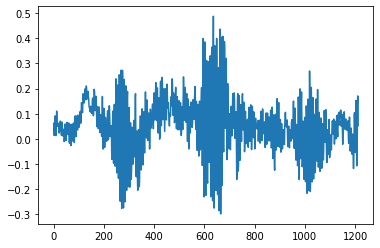

In [ ]:
import argparse
from contextlib import closing
from more_itertools import time_limited
import numpy as np

from ouster import client
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

source = pcap.Pcap(pcap_path, info)
#p.sys_ts for time stamp
with closing(source):
    # for p in source:
    #   if isinstance(p, client.ImuPacket):
    #     print(p.gyro_ts/1e+6)
    imu = np.asarray([(p.accel, p.angular_vel) for p in source if isinstance(p, client.ImuPacket)])
#10ms dt
#accel in G.
xacc = pd.Series(imu[:,0,0])
yacc = pd.Series(imu[:,0,1])
zacc = pd.Series(imu[:,0,2])
#gyro deg/second
xgyro = pd.Series(imu[:,1,0])
ygyro = pd.Series(imu[:,1,1])
zgyro = pd.Series(imu[:,1,2])
p = plt.plot(xacc.index, xacc.values)


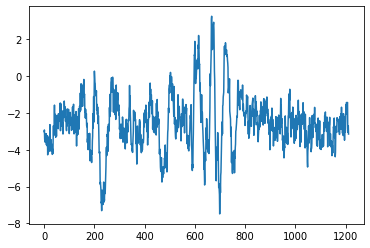

In [ ]:
p = plt.plot(xgyro.index, xgyro.values)

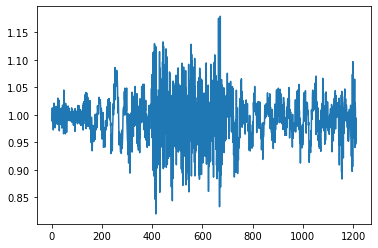

In [ ]:
p = plt.plot(zacc.index, zacc.values)

##IMU 6 axis quaternion/kalman filter
https://github.com/Mayitzin/ahrs/

Parameters:	

    q (numpy.ndarray) – A-priori quaternion.
    gyr (numpy.ndarray) – Sample of tri-axial Gyroscope in rad/s
    acc (numpy.ndarray) – Sample of tri-axial Accelerometer in m/s^2
    dt (float, default: None) – Time step, in seconds, between consecutive Quaternions.


In [ ]:
import ahrs
from ahrs import QuaternionArray

#G to m/s^2
#dps to rad/s
#ahrs.DEG2RAD
#ahrs.MEAN_NORMAL_GRAVITY 9.7976432223
#from 10ms dt -> 100Hz
attitude = ahrs.filters.Madgwick(acc=imu[:,0,:]*ahrs.MEAN_NORMAL_GRAVITY, gyr=imu[:,1,:]*ahrs.DEG2RAD, frequency = 100.0)
#print(attitude.Q.shape)

quat_array = QuaternionArray(attitude.Q)
euler_array = quat_array.to_angles()

#back to DEG
pitch = pd.Series(euler_array[:,0]*ahrs.RAD2DEG)
roll = pd.Series(euler_array[:,1]*ahrs.RAD2DEG)
yaw = pd.Series(euler_array[:,2]*ahrs.RAD2DEG)




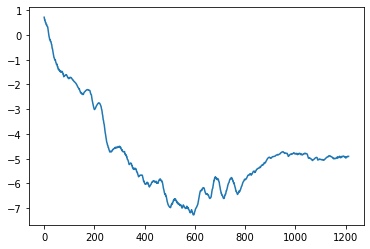

In [ ]:
p = plt.plot(pitch.index, pitch.values)

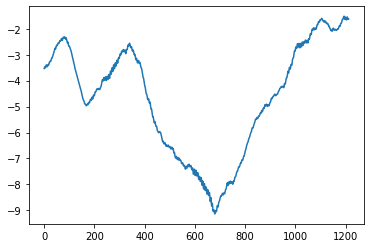

In [ ]:
p = plt.plot(roll.index, roll.values)

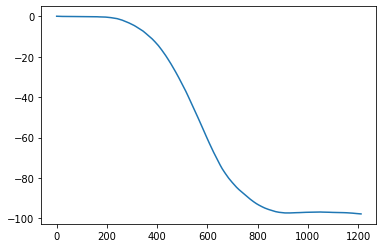

In [ ]:
p = plt.plot(yaw.index, yaw.values)

LET ME GUESS: THE CAR MADE A TURN ON THE INTERSECTION. <br>
6-DOF leaves out heading information (though this 6-DOF does it's best with yaw rate still fed form the gyro) and that can only be completed by a magnetic compass to correct against the eventual yaw gyro drift. <br>
Unfortunately, a functional magnetic compass with its due soft/hard iron calibration is impossible within en electromechnical system like Lidars where high E field fluctuation can easily jam hard calibrated magnetic compass onboard.<br>
If you want high performance heading correction, you'll either have to use a separate 9-DOF IMU or rely on SLAM odometry's additional information. 